<a id="1"></a>
<div style="text-align:center; color:black; margin:20px 0; font-size:180%; font-family:Arial; background-color:#eaf4fc; border-radius:10px; padding:10px; border:1px solid #91c9fc;">
<b>🍄Mushroom Classification Project🍄</b>
</div>

![mushroom](https://www.boglarchamp.ro/wp-content/uploads/2021/10/gombak_0000_Layer-9-1200x600.jpg)

<a id="1"></a>
<div style="text-align:left; color:black; margin:20px 0; font-size:140%; font-family:Arial; background-color:#eaf4fc; border-radius:10px; padding:10px; border:1px solid #91c9fc;">
<b>📕 Table of Contents</b>
</div>

- <a href="#libraries">1. Installing Required Libraries</a>
- <a href="#data">2. Reading and Understanding our Data</a>
- <a href="#outliers">3. Handling Outliers</a>
- <a href="#visual">4. Data Visualization</a>
- <a href="#prepr">5. Data Preprocessing</a>
    - <a href="#sep">5.1. Separate features and target</a>
    - <a href="#scale">5.2. Data Scaling</a>
    - <a href="#split">5.3. Train / Test Split</a>      
- <a href="#ml">6. Machine Learning</a> 
    - <a href="#log">6.1. Logistic Regression</a>
    - <a href="#knn">6.2. K Nearest Neighbors</a>

<a id='libraries'></a>
<div style="text-align:left; color:black; margin:20px 0; font-size:140%; font-family:Arial; background-color:#eaf4fc; border-radius:10px; padding:10px; border:1px solid #91c9fc;">
<b>1. Installing Required Libraries</b>
</div>

In [ ]:
import pandas as pd
import numpy as np 

import seaborn as sns 
import matplotlib.pylab as plt
%matplotlib inline

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

<a id='data'></a>
<div style="text-align:left; color:black; margin:20px 0; font-size:140%; font-family:Arial; background-color:#eaf4fc; border-radius:10px; padding:10px; border:1px solid #91c9fc;">
<b>2. Reading and Understanding our Data</b>
</div>

Let's read the data into *pandas* dataframe and look at the first 5 rows using the `head()` method. 

In [3]:
df = pd.read_csv('/kaggle/input/mushroom-dataset/mushroom_cleaned.csv')
df.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


Let's find out how many entries there are in our dataset, using `shape` function.

In [4]:
df.shape

(54035, 9)

Using `dtypes` function, we will take a look at our column names and types of data.

In [5]:
df.dtypes

cap-diameter         int64
cap-shape            int64
gill-attachment      int64
gill-color           int64
stem-height        float64
stem-width           int64
stem-color           int64
season             float64
class                int64
dtype: object

Below, we will check for any **missing values**.


In [6]:
df.isnull().sum()

cap-diameter       0
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         0
stem-color         0
season             0
class              0
dtype: int64

Now, let's provide **descriptive statistics**. 

In [7]:
df.describe().iloc[1:]

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
mean,567.257204,4.000315,2.142056,7.329509,0.759110,1051.081299,8.418062,0.952163,0.549181
std,359.883763,2.160505,2.228821,3.200266,0.650969,782.056076,3.262078,0.305594,0.497580
min,0.000000,0.000000,0.000000,0.000000,0.000426,0.000000,0.000000,0.027372,0.000000
25%,289.000000,2.000000,0.000000,5.000000,0.270997,421.000000,6.000000,0.888450,0.000000
50%,525.000000,5.000000,1.000000,8.000000,0.593295,923.000000,11.000000,0.943195,1.000000
75%,781.000000,6.000000,4.000000,10.000000,1.054858,1523.000000,11.000000,0.943195,1.000000
max,1891.000000,6.000000,6.000000,11.000000,3.835320,3569.000000,12.000000,1.804273,1.000000


Next, we will calculate the **correlation** between `class` and all other columns in df.

In [8]:
df_corr = df.corr()['class'][:-1] # -1 to remove the last row which is class
df_corr.sort_values()

stem-width        -0.182856
cap-diameter      -0.165676
cap-shape         -0.133338
stem-color        -0.128339
season            -0.082919
gill-color        -0.063947
gill-attachment   -0.052541
stem-height        0.183354
Name: class, dtype: float64

#### Observations from Data Exploration:
- Dataset has **54035** rows and **9** columns. 
- Data type of  all columns is numerical (float or integer).
- All values are **non-null**. 
- **Correlation** between `class` and feature columns in df is **low**, absolute value ranging between 5% and 18.3%.

<a id='outliers'></a>
<div style="text-align:left; color:black; margin:20px 0; font-size:140%; font-family:Arial; background-color:#eaf4fc; border-radius:10px; padding:10px; border:1px solid #91c9fc;">
<b>3. Handling Outliers</b>
</div>

Let's explore **outliers**. For this, we will calculate the **z-scores** for each column in the DataFrame df, then provide descriptive statistics of these z-scores rounded to three decimal places. 

Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured. In another words, Z-score is the value that quantifies relationship between a data point and a standard deviation and mean values of a group of points. Data points which are too far from zero will be treated as the outliers. In most of the cases, a threshold of 3 or -3 is used. For example, if the Z-score value is greater than or less than 3 or -3 standard deviations respectively, that data point will be identified as a outlier.

To learn more about Z-score, please visit this [Wikipedia](https://en.wikipedia.org/wiki/Standard_score?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0232ENSkillsNetwork837-2023-01-01) site. 

In [9]:
# Calculate the z-scores for each column
z_scores = pd.DataFrame(stats.zscore(df), columns=df.columns)

# Generate descriptive statistics for the z-scores
z_scores.describe().round(3)

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
count,54035.000,54035.000,54035.000,54035.000,54035.000,54035.000,54035.000,54035.000,54035.000
mean,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.576,-1.852,-0.961,-2.290,-1.165,-1.344,-2.581,-3.026,-1.104
25%,-0.773,-0.926,-0.961,-0.728,-0.750,-0.806,-0.741,-0.208,-1.104
50%,-0.117,0.463,-0.512,0.210,-0.255,-0.164,0.792,-0.029,0.906
75%,0.594,0.926,0.834,0.834,0.454,0.603,0.792,-0.029,0.906
max,3.678,0.926,1.731,1.147,4.726,3.220,1.098,2.788,0.906


In 4 columns of our dataframe, there are absolute values with **Z-score higher than 3**: `stem-height` (max z-score = 4.7), `cap-diameter` (max z-score = 3.7), `stem-width` (max z-score = 3.2) and `season` (min z_score = -3.026).

Let's drop rows containing outliers (with Z-score > 3).

In [10]:
# Identify rows where any of the z-scores exceed the threshold
outliers = z_scores[(np.abs(z_scores) > 3).any(axis=1)]

# Drop the identified rows containing outliers
df_no_outliers = df.drop(outliers.index)

In [11]:
# Calculate number of rows of original dataframe, of new one and how many rows were removed
new_num_r = df_no_outliers.shape[0]
old_num_r = df.shape[0]
removed = old_num_r - new_num_r

print("New dataframe has {} rows. {} rows were removed.".format(new_num_r, removed))

New dataframe has 50397 rows. 3638 rows were removed.


<a id='visual'></a>
<div style="text-align:left; color:black; margin:20px 0; font-size:140%; font-family:Arial; background-color:#eaf4fc; border-radius:10px; padding:10px; border:1px solid #91c9fc;">
<b>4. Data Visualization</b>
</div>

Plot distributions of all columns with a hue `class` in Seaborn, we will use `sns.displot()` function.

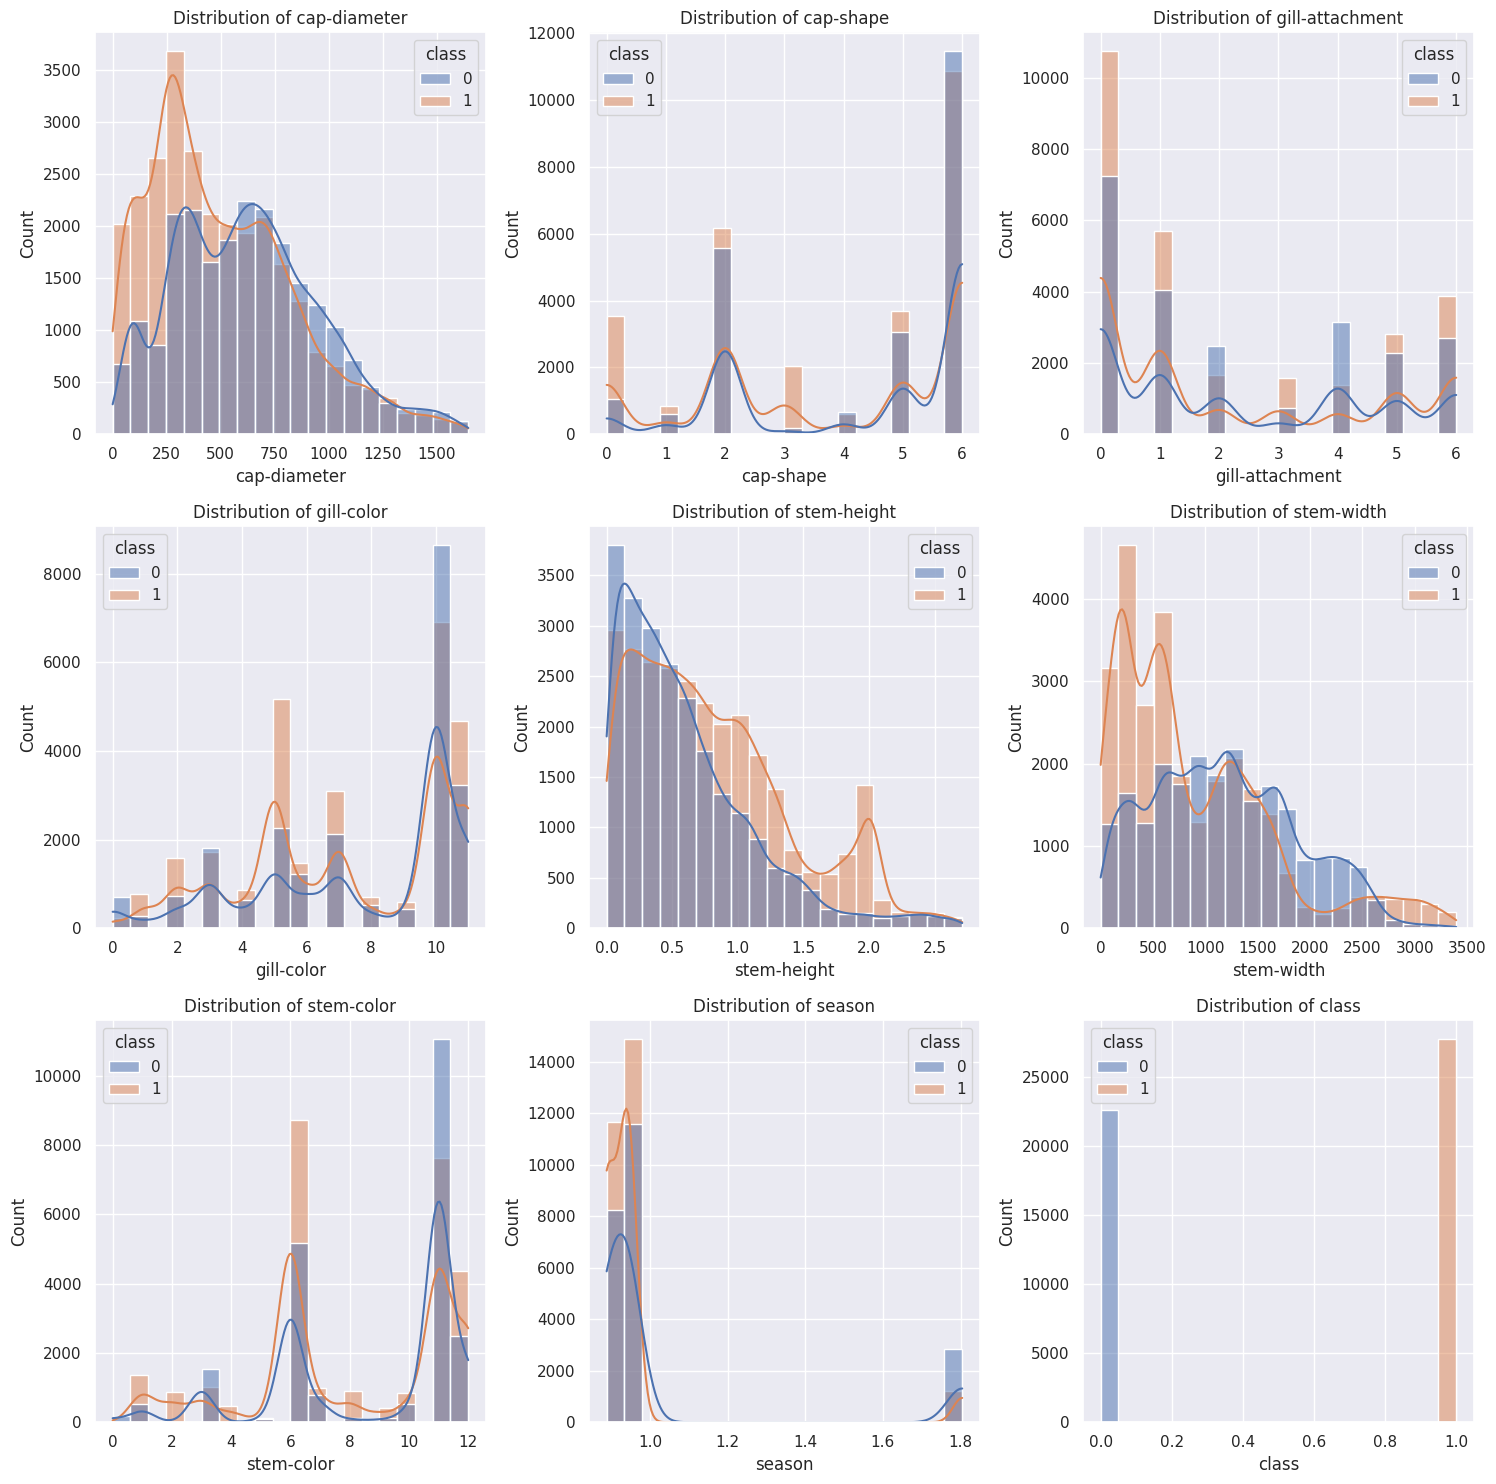

In [12]:
# Set Seaborn style
sns.set()

# Create subplots with 3 columns and 3 rows
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each column in the DataFrame
for i, column in enumerate(df_no_outliers.columns):
    # Create a histogram plot for the current column with hue
    sns.histplot(data=df_no_outliers, x=column, hue='class', kde=True, bins=20, ax=axes[i])
    
    # Set title for the plot
    axes[i].set_title(f'Distribution of {column}')
    
# Adjust layout to prevent overlap of titles
plt.tight_layout()

# Display the plot
plt.show()


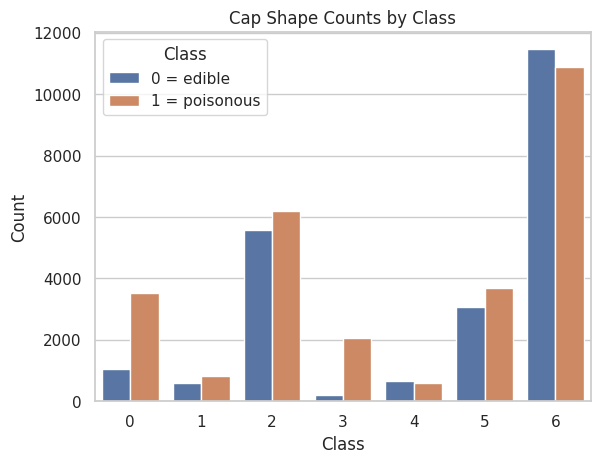

In [13]:
sns.set(style="whitegrid")

# Create a count plot to visualize the distribution of 'cap-shape' with hue by 'class'
sns.countplot(hue='class', x='cap-shape', data=df_no_outliers)

# Adding title and labels
plt.title('Cap Shape Counts by Class')
plt.legend(title='Class', labels=['0 = edible', '1 = poisonous'])
plt.xlabel('Class')
plt.ylabel('Count')

plt.show()

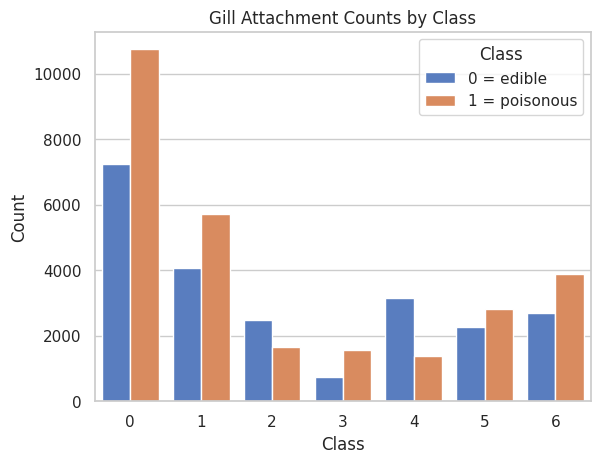

In [14]:
sns.set(style="whitegrid", palette="muted", color_codes=True)

# Create a count plot to visualize the distribution of 'gill-attachment' with hue by 'class'
sns.countplot(hue='class', x='gill-attachment', data=df_no_outliers)

# Adding title and labels
plt.title('Gill Attachment Counts by Class')
plt.legend(title='Class', labels=['0 = edible', '1 = poisonous'])
plt.xlabel('Class')
plt.ylabel('Count')

plt.show()

#### Observations from visualizations above: 
- Differences between classes are evident in the histograms and count plots. On average poisonous mushrooms have smaller cap diameters and taller, slimmer stems compared to edible ones.

<a id='prepr'></a>
<div style="text-align:left; color:black; margin:20px 0; font-size:140%; font-family:Arial; background-color:#eaf4fc; border-radius:10px; padding:10px; border:1px solid #91c9fc;">
<b>5. Data Preprocessing</b>
</div>

<a id="sep"></a>
<div style="text-align:left; color:black; margin:15px 0; font-size:120%; font-family:Arial; background-color:#f0f9ff; border-radius:8px; padding:8px; border:1px solid #91c9fc;">
<b>5.1. Separate Features and Target</b>
</div>

Set a **variable X** equal to the numerical features and a **variable y** equal to the "class" column.

In [15]:
X = df_no_outliers.loc[:, df_no_outliers.columns != "class"]
y = df_no_outliers['class']

<a id="scale"></a>
<div style="text-align:left; color:black; margin:15px 0; font-size:120%; font-family:Arial; background-color:#f0f9ff; border-radius:8px; padding:8px; border:1px solid #91c9fc;">
<b>5.2. Data Scaling</b>
</div>

It is important to get all attributes to have the same scale. One of the common ways to do it is standardization: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation, so that the resulting distribution has unit variance.

Scikit-learn library provides `StandardScaler` for standardization needs.

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

<a id='split'></a>
<div style="text-align:left; color:black; margin:15px 0; font-size:120%; font-family:Arial; background-color:#f0f9ff; border-radius:8px; padding:8px; border:1px solid #91c9fc;">
<b>5.3. Train / Test Split</b>
</div>

Split the data into training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101, stratify=y)

<a id='ml'></a>
<div style="text-align:left; color:black; margin:20px 0; font-size:140%; font-family:Arial; background-color:#eaf4fc; border-radius:10px; padding:10px; border:1px solid #91c9fc;">
<b>6. Machine Learning</b>
</div>

<a id='log'></a>
<div style="text-align:left; color:black; margin:15px 0; font-size:120%; font-family:Arial; background-color:#f0f9ff; border-radius:8px; padding:8px; border:1px solid #91c9fc;">
<b>6.1. Logistic Regression</b>
</div>

Using cross validation, let's determine the hyperparameters and fit models using L1 and L2 regularization.

In [ ]:
# Define a custom grid for Cs to ensure a wide range of values are tested
custom_cs = [0.001, 0.01, 0.1, 1, 10, 100]

# L1 regularized logistic regression with cross-validation
lr_l1 = LogisticRegressionCV(Cs=custom_cs, cv=5, penalty='l1', solver='liblinear', verbose=0)

# Fit the model on the training data
lr_l1.fit(X_train, y_train)

# Extract the best C value
best_C = lr_l1.C_[0]
print(f"Best C value: {best_C}")
print("\n")

# Extract the coefficients of the best model
best_coefficients = lr_l1.coef_
print(f"Coefficients of the best model: {best_coefficients}")
print("\n")

# Extract the mean cross-validated scores for each fold and each parameter
cv_scores = lr_l1.scores_[1]  # Assuming binary classification with target classes 0 and 1
print(f"Cross-validated scores for each parameter: {cv_scores}")
print("\n")

# Optionally, you can also find the mean cross-validated score for the best parameter
best_score = cv_scores.mean(axis=0)[custom_cs.index(best_C)]
print(f"Mean cross-validated score for the best C value: {best_score}")

Best C value: 0.01


Coefficients of the best model: [[-0.17995057 -0.19821805  0.01498655 -0.04801375  0.47372532 -0.20843884
  -0.22027457 -0.31917766]]


Cross-validated scores for each parameter: [[0.64243197 0.64597506 0.64512472 0.64526644 0.64484127 0.64484127]
 [0.64058957 0.64710884 0.64526644 0.64512472 0.64526644 0.64526644]
 [0.64932672 0.65527994 0.65499646 0.65527994 0.65527994 0.65527994]
 [0.6443657  0.64819277 0.64932672 0.64890149 0.64875974 0.64875974]
 [0.64408221 0.64975195 0.65031892 0.65060241 0.65060241 0.65074415]]


Mean cross-validated score for the best C value: 0.6492617127172153


In [19]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=custom_cs, cv=5, penalty='l2', solver='liblinear')
lr_l2.fit(X_train, y_train)

# Extract the best C value
best_C = lr_l2.C_[0]
print(f"Best C value: {best_C}")
print("\n")

# Extract the coefficients of the best model
best_coefficients = lr_l2.coef_
print(f"Coefficients of the best model: {best_coefficients}")
print("\n")

# Extract the mean cross-validated scores for each fold and each parameter
cv_scores = lr_l2.scores_[1]  # Assuming binary classification with target classes 0 and 1
print(f"Cross-validated scores for each parameter: {cv_scores}")
print("\n")

# Optionally, you can also find the mean cross-validated score for the best parameter
best_score = cv_scores.mean(axis=0)[custom_cs.index(best_C)]
print(f"Mean cross-validated score for the best C value: {best_score}")

Best C value: 0.001


Coefficients of the best model: [[-0.17497572 -0.18497653  0.01889231 -0.05629912  0.42247424 -0.19639139
  -0.20185927 -0.28859273]]


Cross-validated scores for each parameter: [[0.64668367 0.64569161 0.64498299 0.64498299 0.64498299 0.64498299]
 [0.6468254  0.64512472 0.64512472 0.64512472 0.64512472 0.64512472]
 [0.65967399 0.65712261 0.65527994 0.65527994 0.65527994 0.65527994]
 [0.65386251 0.64989369 0.64904323 0.64890149 0.64875974 0.64875974]
 [0.65017718 0.65046067 0.65074415 0.65060241 0.65060241 0.65060241]]


Mean cross-validated score for the best C value: 0.6514445497074333


#### The scores are quite low and very similar. Let's proceed with the L2 regularized model.

#### Now, we will predict the class for L2 regularized model

In [20]:
l2_preds = lr_l2.predict(X_test)

#### Evaluate the model


In [ ]:
print(classification_report(y_test, l2_preds))

              precision    recall  f1-score   support

           0       0.62      0.55      0.59      6794
           1       0.67      0.73      0.69      8326

    accuracy                           0.65     15120
   macro avg       0.64      0.64      0.64     15120
weighted avg       0.65      0.65      0.65     15120



#### Confusion Matrix

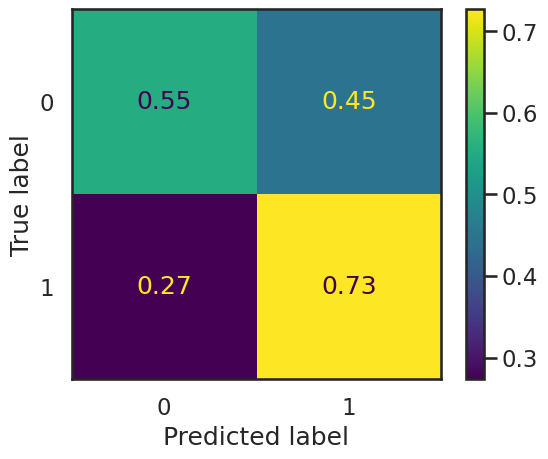

In [22]:
cf = confusion_matrix(y_test, l2_preds, normalize='true')

sns.set(style="white", context="talk")
disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot()
plt.show()

#### As we can see, 73% of poisonous mushrooms are labeled correctly. But we have a big confusion in edible mushrooms, almost half of them (45%) are labeled as poisonous. We will need different model. Let's try another simple model KNN.

<a id='knn'></a>
<div style="text-align:left; color:black; margin:15px 0; font-size:120%; font-family:Arial; background-color:#f0f9ff; border-radius:8px; padding:8px; border:1px solid #91c9fc;">
<b>6.2. K Nearest Neighbors</b>
</div>

We will start with k=1, and later will choose better K value. 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [24]:
knn_preds = knn.predict(X_test)

#### Evaluation

In [25]:
print(confusion_matrix(y_test,knn_preds))

[[6687  107]
 [ 119 8207]]


In [26]:
print(classification_report(y_test, knn_preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6794
           1       0.99      0.99      0.99      8326

    accuracy                           0.99     15120
   macro avg       0.98      0.98      0.98     15120
weighted avg       0.99      0.99      0.99     15120



### Choosing a K Value

In [27]:
error_rate = []

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

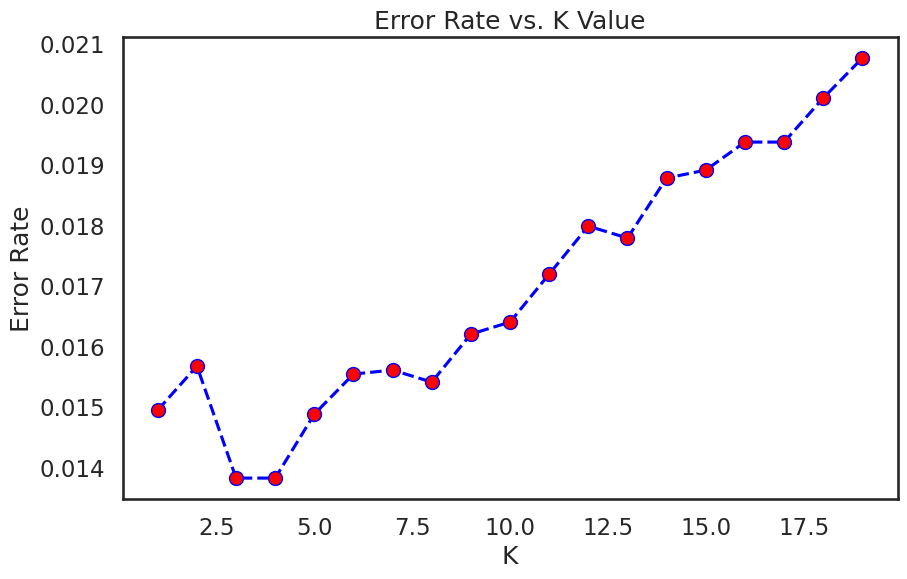

In [28]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20), error_rate, color='blue', linestyle='dashed', marker='o',
        markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate');

Here we can see that at K=3 the error rate is the lowest and it's around 0.013. Let's retrain the KNN model with K=3 and check the classification report!

In [29]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train,y_train)
knn_preds = knn.predict(X_test)

print('K Nearest Neighbors')
print('\n')
print(confusion_matrix(y_test,knn_preds))
print('\n')
print(classification_report(y_test,knn_preds))

K Nearest Neighbors


[[6688  106]
 [ 103 8223]]


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6794
           1       0.99      0.99      0.99      8326

    accuracy                           0.99     15120
   macro avg       0.99      0.99      0.99     15120
weighted avg       0.99      0.99      0.99     15120



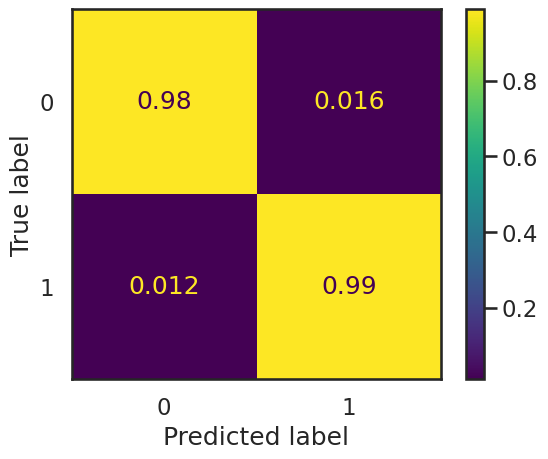

In [30]:
cf = confusion_matrix(y_test, knn_preds, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=knn.classes_)
disp.plot()
plt.show()

<a id='end'></a>
<div style="text-align:center; color:black; margin:20px 0; font-size:140%; font-family:Arial; background-color:#eaf4fc; border-radius:10px; padding:10px; border:1px solid #91c9fc;">
<b>Thank You</b>
</div>